# [Temporal regularization in Markov Decision Process](https://arxiv.org/pdf/1811.00429.pdf)

In [1]:
import numpy as np
from numpy import random as rd
from numpy import linalg as LA 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from functools import lru_cache
# custom module, need to dowload it : https://github.com/sauxpa/ML_101/tree/master/RL/rl_module
import rl_module as rl

# Define Markov Reward Process class

In [2]:
class MRP(rl.Environment):
    """Generic class for Markov Reward Process
    Inputs are transition matrix p(s,s') and reward function r(s,s')
    """
    def __init__(self, P, reward):
        super().__init__()
        # transition matrix : p(s_j-->s_i)=P_ij
        self._P = P
        # number of states
        self._N = len(P)
        # reward vector : r(s_j-->s_i) = r_ij
        self._reward = reward
        
    @property
    def P(self):
        return self._P
    
    @P.setter
    def P(self, new_P):
        self._P = new_P
    
    @property
    def expectedReward(self):
        """
        Expected next reward given current state
        """
        return np.diag(np.dot(self._reward.T, self._P))
    
    def actionStateMap(self, state):
        reachable_states=[i for i in range(self._N) if self._P[i, state]]
        return dict(zip(reachable_states, reachable_states))    
    
    def getReward(self, state=None, next_state=None):
        return(self._reward[(state, next_state)])

    def isTerminal(self, state=None):
        return False
    
    def summary(self):
        print('Transition matrix:')
        print(self._P)
        print('\nReward matrix:')
        print(self._reward)
        
    # memoization to ensure no time is wasted calculating the stationary distribution over and over again
    @lru_cache(maxsize=None)
    def stationary(self):
        # stationary distribution is the eigenvector for the transition matrix
        # associated with eigenvalue 1 (always exists since P is stochastic), up to rescaling
        # WARNING: P is defined here as the transpose of the usual transition matrix. 
        eig_val, eig_vec = LA.eig(self.P)
        
        # select eigenvector associated with eigenvalue 1, with tolerance 1e-12 on the eigenvalue 
        mu = np.real(np.array(eig_vec[:, np.where(np.abs(eig_val - 1.) < 1e-12)[0][0]]))
        
        # check that indeed P*mu=mu
        if(np.abs(max(np.dot(self.P, mu)-mu))<1e-12):
            # normalize the stationary vector
            mu /= mu.sum(0)
            # matrix with columns = mu
            # P^n --> P_inf
            P_inf = np.array([mu,]*self._N).T
            
            # matrix such that
            # P_reverse[i,j] = mu[i]/mu[j]*P[j,i]
            top = np.dot(self.P, (np.multiply(mu, np.eye(self._N))))
            P_reverse = (top/P_inf).T
            
            return {
                'stationary_distribution': mu, 
                'P_reverse': P_reverse,
                'P_inf': P_inf,
            }
        else:
            raise NameError( "Failed to calculate stationary distribution using eigenvector method" )

    def regP(self, beta):
        """
        Regularized transition matrix beta*P + (1-beta)*P_reverse
        """
        P_reverse = self.stationary().get('P_reverse')
        # temporal regularization computes the convex combination of P and the reverse chain 
        return (1-beta)*self._P+beta*P_reverse
    
    def exactValueFunction(self, discount_factor = 1, beta = 0):
        if discount_factor == 1:
            # because 1 is an eigenvalue of P
            print('Warning : discount factor == 1, potential singular matrix to invert')
    
        if discount_factor > 1:
            raise NameError( "Discount factor should be between 0 and 1" )
        
        P = self.regP(beta)
        return LA.solve(np.eye(len(P))-discount_factor*P, self.expectedReward)

    def iterativeValueFunction(self, discount_factor = 1, beta = 0, l_exp_smoothing = 0, learning_rate = 0, num_iter = 0):
        if discount_factor == 1:
            # because 1 is an eigenvalue of P
            print('Warning : discount factor == 1, potential singular problem')
    
        if discount_factor > 1:
            raise NameError( "Discount factor should be between 0 and 1" )
        
        P = self.regP(beta)
        N = len(P)
        
        # value function, random initialization
        V = np.array(rd.uniform(size=N))
        temp = 0.
        
        # start at a random state
        state = rd.choice(N)

        for _ in range(num_iter):
            # take action, observe next_state and reward
            new_state = rd.choice(N, p=P[:, state])
            reward = self._reward[new_state, state]    
            TD_target = reward + discount_factor * ((1 - beta) * V[new_state] + beta * temp) - V[state]
            V[state] += learning_rate * TD_target
            temp = (1 - l_exp_smoothing) * V[state] + l_exp_smoothing * temp
            state = new_state
        
        return V

### Create a synthetic MRP with 5 states and transition probabilities sampled from uniform distribution

In [3]:
def randomMRP(N):
    """
    Create a random transition matrix and a random reward matrix
    """
    P = np.array(rd.uniform(size=(N,N)))
    r = np.array(rd.uniform(size=(N,N)))
    return P / P.sum(0), r

In [4]:
N = 5
P, reward = randomMRP(N)
Markov = MRP(P, reward)
Markov.summary()

Transition matrix:
[[0.30362532 0.15889646 0.35078187 0.2306334  0.36311538]
 [0.0039455  0.37087611 0.3173806  0.31245501 0.01933018]
 [0.26941414 0.09539098 0.27649753 0.15811414 0.14385081]
 [0.13099847 0.1681737  0.0389219  0.08816474 0.22393126]
 [0.29201656 0.20666275 0.0164181  0.21063272 0.24977237]]

Reward matrix:
[[0.32466979 0.40520393 0.50868442 0.62079215 0.61824211]
 [0.25033467 0.78886124 0.14596567 0.59500418 0.65498247]
 [0.23412056 0.13964147 0.46038078 0.36520742 0.21468242]
 [0.67700355 0.97989307 0.40138014 0.15482798 0.02103751]
 [0.05262925 0.33291348 0.08182287 0.54174414 0.75715024]]


In [5]:
# create the temporally regularized chain
beta = 0.5
reg_P = Markov.regP(beta)

# Mixing Time

In [6]:
def plotResultMixingTime(err):
    fig = plt.figure(figsize=(8, 7))
    ax = plt.axes(projection='3d')

    err = np.array(err)
    iters = err[:,0]
    betas = err[:,1]
    err_plot_reg = err[:,2]

    ax.plot_trisurf(iters, betas, err_plot_reg)
    
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Err_inf')

    plt.tight_layout()
    plt.show()
    
def mixingTime(num_sim = 0, num_iter = 0, num_beta = 0, n_chain = 10):
    """
    num_sim  : number of independent trials : for each trial, a new random chain is built using randomChain()
    num_iter : number of exponentiation of the transition matrix per trial : P^i --> P_inf
    num_beta : number of knots in the beta grid
    n_chain  : number of states in the randomly generated Markov chains
    """
    betas = np.linspace(0, 1, num_beta)
    err = []
    
    for sim in range(num_sim):
        P, r = randomMRP(n_chain)
        Markov = MRP(P, r)
        P_inf = Markov.stationary().get('P_inf')
        
        for n_power in range(1, num_iter+1):
            for beta in betas:
                reg_P = Markov.regP(beta)
                err_reg = np.abs(np.max(P_inf-LA.matrix_power(reg_P, n_power)))
                err.append([sim, n_power, beta, err_reg])
    df = pd.DataFrame(err, columns=['sim', 'power', 'beta', 'err'])
    df = df.groupby(['power', 'beta'], as_index=False).mean().drop('sim', axis=1)
    plotResultMixingTime(df.values)
    return df

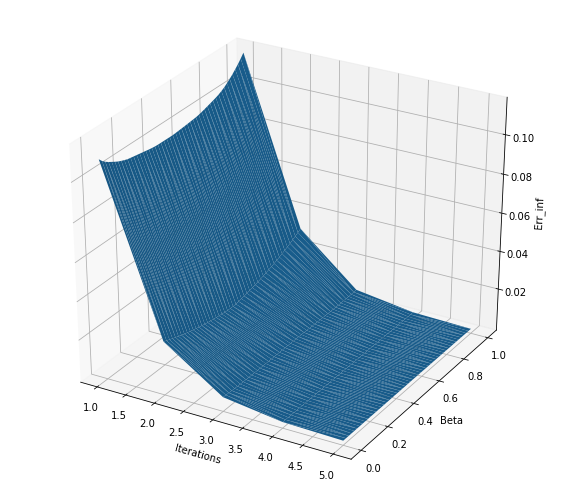

In [7]:
df = mixingTime(num_sim=20, num_iter=5, num_beta=50, n_chain = 10)

# Estimate bias

In [8]:
def smoothTemporalReward(reward, P, num_step=len(P), num_iter=len(P)):
    """Takes an arbitrary reward matrix (e.g uniformly sampled) and a transition matrix
    Then simulate n_iter times a n_step walk starting from a random state and update the reward for each observed transition
    with the formula : 
    r(s_t) <- (r(s_t)+r(s_t+1))/2
    This creates a temporal smoothing of the reward along the likely trajectory of the graph
    """
    N = len(P)
    reward_smooth = reward.copy()
    for _ in range(num_iter):
        state = rd.choice(N)
        old_reward = rd.uniform()
        for _ in range(num_step):
            new_state = rd.choice(N, p=P[:, state])
            reward_smooth[new_state, state] += (old_reward-reward_smooth[new_state, state])/2
            old_reward = reward_smooth[new_state, state]
            state = new_state
    return reward_smooth

Test on a cyclic graph where each state i transition with probability 1 to i+1 mod N

In [9]:
N = 4
P = np.array([[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,0,0,0]]).T
reward = np.array(rd.uniform(size=(N,N)))*P
reward_smooth = smoothTemporalReward(reward, P, num_step = 50, num_iter=100)
print("Random reward:\n", reward, "\n\nSmoothed reward:\n", reward_smooth)

Random reward:
 [[0.         0.         0.         0.4103591 ]
 [0.65126875 0.         0.         0.        ]
 [0.         0.93968642 0.         0.        ]
 [0.         0.         0.00516809 0.        ]] 

Smoothed reward:
 [[0.         0.         0.         0.52414598]
 [0.52414506 0.         0.         0.        ]
 [0.         0.5241491  0.         0.        ]
 [0.         0.         0.52414932 0.        ]]


In [10]:
def plotResultBias(df, num_step_reg):
    fig = plt.figure(figsize=(8, 7))
    ax = plt.axes()

    for n_step in range(1, num_step_reg+1):
        err = df[df['step'] == n_step].drop(columns=['step']).values
        ax.plot(err[:, 0], err[:, 1], label='N={}'.format(n_step))
    
    ax.set_xlabel('Beta')
    ax.set_ylabel('Bias')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
def testBetaBias(num_sim = 0, num_step_reg = 0, num_beta = 0, n_chain = 0, discount_factor = 0.9):
    """
    num_sim         : number of independent trials : for each trial, a new random chain is built using randomChain()
    num_step_reg    : number of reward smoothing steps
    num_beta        : number of knots in the beta grid
    n_chain         : number of states in the randomly generated Markov chains
    discount_factor : discount factor for future rewards
    """
    if discount_factor == 1:
        # because 1 is an eigenvalue of P
        print('Warning : discount factor == 1, singular matrix to invert')
    
    if discount_factor > 1:
        raise NameError( "Discount factor should be between 0 and 1" )
        
    betas = np.linspace(0.01, 1, num_beta)   
    err = []
    
    for sim in range(num_sim):
        P, reward = randomMRP(n_chain)

        for n_step in range(1, num_step_reg+1):
            reward_smooth = smoothTemporalReward(reward, P, num_step = n_step, num_iter = 50)
            Markov = MRP(P, reward_smooth)
            V = Markov.exactValueFunction(discount_factor = discount_factor, beta = 0)

            for beta in betas:
                V_reg = Markov.exactValueFunction(discount_factor = discount_factor, beta = beta)
                err_reg = np.abs(V-V_reg).mean()
                err.append([sim, n_step, beta, err_reg])
    
    df = pd.DataFrame(err, columns=['sim', 'step', 'beta', 'err'])
    df = df.groupby(['step', 'beta'], as_index=False).mean().drop('sim', axis=1)
    
    plotResultBias(df, num_step_reg)
    return df

Here it seems we adopt a slightly different methodology than in the article : the different scenarios for N (the number of temporal smoothing steps) share the same simulations (i.e for each of the n_sim simulations, the 4 values of N are tested), which produces smoother bias curve. Nonetheless, the bias reduction effect for more temporally smoothed graphs is clear

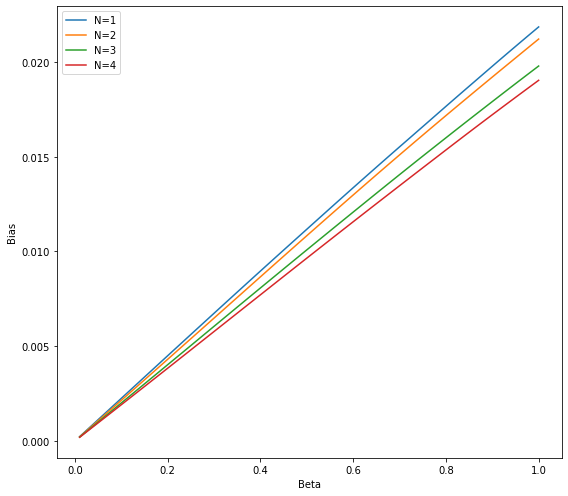

In [11]:
df = testBetaBias(num_sim = 50, num_step_reg = 4, num_beta = 50, n_chain = 10, discount_factor = 0.90)

# Check convergence of iterative policy evaluation

In [12]:
def plotResultConvergence(err):
    fig = plt.figure(figsize=(8, 7))
    ax = plt.axes(projection='3d')

    err = np.array(err)
    iters = err[:,0]
    betas = err[:,1]
    err_plot = err[:,2]

    ax.plot_trisurf(iters, betas, err_plot)
    
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Convergence error')

    plt.tight_layout()
    plt.show()
    
def testConvergence(num_sim = 0, num_iter_max = 0, num_beta = 0, n_chain = 0, discount_factor = 0.9, learning_rate = 0, temporal_smoothing = False):
    """
    num_sim            : number of independent trials : for each trial, a new random chain is built using randomChain()
    num_iter_max       : number of values tested for num_iter in the iterative policy evaluation
    num_beta           : number of knots in the beta grid
    n_chain            : number of states in the randomly generated Markov chains
    discount_factor    : discount factor for future rewards
    learning_rate      : learning rate for TD learning
    temporal_smoothing : boolean, weither to smooth the reward or not
    """
        
    betas = np.linspace(0.01, 1, num_beta)   
    err = []
    
    for sim in range(num_sim):
        P, reward = randomMRP(n_chain)
        if temporal_smoothing:
            reward = smoothTemporalReward(reward, P, num_step = N, num_iter = 50)
        Markov = MRP(P, reward)
        
        for beta in betas:
            # exact value function
            V = Markov.exactValueFunction(discount_factor = discount_factor, beta = beta)

            for num_iter_log in range(num_iter_max):
                num_iter = 2 ** num_iter_log
                V_iter = Markov.iterativeValueFunction(discount_factor = discount_factor, 
                                                       beta = beta,
                                                       l_exp_smoothing = 0, 
                                                       learning_rate = learning_rate, 
                                                       num_iter = num_iter)
                err_iter = np.abs(V-V_iter).mean()
                err.append([sim, num_iter_log, beta, err_iter])
    
    df = pd.DataFrame(err, columns=['sim', 'iter_log', 'beta', 'err'])
    df = df.groupby(['iter_log', 'beta'], as_index=False).mean().drop('sim', axis=1)
    
    plotResultConvergence(df.values)
    return df

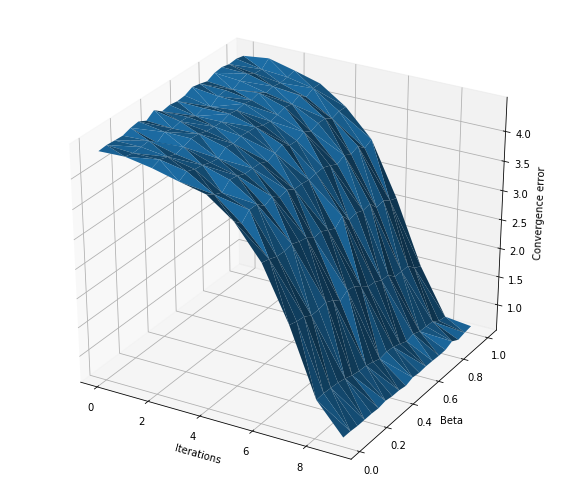

In [13]:
df = testConvergence(num_sim = 5, num_iter_max = 10, num_beta = 20, n_chain = 10, discount_factor = 0.9, learning_rate = 0.5, temporal_smoothing = True)

# Variance

Test on a 4 state user-defined chain

In [14]:
N = 4
reward = np.array([[0, 1, 0, 0], [1, 0, 1, 1], [0, 0, 0, 0], [0, 2, 0, 0]])
P = np.array([[0, 0.5, 0, 0], [1, 0, 1, 1], [0, 0.25, 0, 0], [0, 0.25, 0, 0]])
Markov = MRP(P, reward)
Markov.summary()

Transition matrix:
[[0.   0.5  0.   0.  ]
 [1.   0.   1.   1.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.  ]]

Reward matrix:
[[0 1 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [0 2 0 0]]


In [15]:
def plotResultVariance(err, var, beta):
    f, (ax1, ax2) = plt.subplots(2, figsize=(8, 7))
    ax1.plot(err[:, 0], err[:, 1], label='beta=0')
    ax1.plot(err[:, 0], err[:, 2], label='beta={}'.format(beta))

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Error')
    ax1.legend()
    
    ax2.plot(var[:, 0], var[:, 1], label='beta=0')
    ax2.plot(var[:, 0], var[:, 2], label='beta={}'.format(beta))

    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Variance')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def testVariance(Markov, state = None, num_sim = 0, num_iter_max = 0, beta=0, discount_factor = 0.9, learning_rate = 0):
    """
    Markov          : user-defined MRP
    state           : state at which the speed of convergence for the value function is evaluated
    num_sim         : number of independent trials : for each trial, a new random chain is built using randomChain()
    num_iter_max    : number of values tested for num_iter in the iterative policy evaluation
    beta            : regularization coefficient
    discount_factor : discount factor for future rewards
    learning_rate   : learning rate for TD learning
    """
        
    err = []
    estim = []
    
    for sim in range(num_sim):
        # exact value function
        V = Markov.exactValueFunction(discount_factor = discount_factor, beta = beta)
        
        for num_iter in range(num_iter_max):
            # iterative TD learning without temporal regularization
            V_iter = Markov.iterativeValueFunction(discount_factor = discount_factor, 
                                                   beta = 0,
                                                   l_exp_smoothing = 0, 
                                                   learning_rate = learning_rate, 
                                                   num_iter = num_iter)
            
            # iterative TD learning with temporal regularization
            V_iter_reg = Markov.iterativeValueFunction(discount_factor = discount_factor, 
                                                   beta = beta,
                                                   l_exp_smoothing = 0, 
                                                   learning_rate = learning_rate, 
                                                   num_iter = num_iter)
            err_iter = np.abs(V-V_iter)[state]
            err_iter_reg = np.abs(V-V_iter_reg)[state]
            
            err.append([sim, num_iter, err_iter, err_iter_reg])
            estim.append([sim, num_iter, V_iter[state], V_iter_reg[state]])
            
    df_err = pd.DataFrame(err, columns=['sim', 'iter', 'err', 'err_reg'])
    df_err = df_err.groupby(['iter'], as_index=False).mean().drop('sim', axis=1)
    
    df_var = pd.DataFrame(estim, columns=['sim', 'iter', 'var', 'var_reg'])
    df_var = df_var.groupby(['iter'], as_index=False).var().drop('sim', axis=1)
    plotResultVariance(df_err.values, df_var.values, beta)
    return df_err, df_var

Again we appear to have a slightly different methodology to conduct the verification than in the article (and the temporal smoothing method is likely implemented differently), but the conclusions are the same : the error decreases faster with temporal beta-regularization and the resulting estimator has less variance.

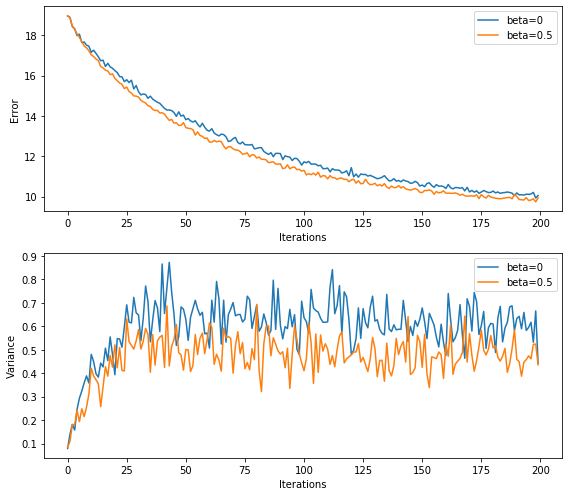

In [16]:
df_err, df_var = testVariance(Markov, state = 1, num_sim = 100, num_iter_max = 200, beta = 0.5, discount_factor = 0.9, learning_rate = 0.5)


## Conclusion 
### The temporal regularization technique for MDP is an example of bias-variance tradeoff : an agent learning the regularized MDP, which is a weighted average of the initial Markov chain and its reversed chain, is optimizing a biased cost function, but the introduction of this bias can lead to improved convergence properties and lower variance in the value function estimation when the MDP exhibits temporally smooth reward trajectories